# Conditional Random Field segmentation

## Init

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, accuracy_score
import datetime as dt
from scipy import signal
import os
from pathlib import Path
from tqdm.auto import tqdm
from pprint import pprint

In [2]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
    get_bagfiles_from_json,
)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

In [4]:
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

## Data files

In [5]:
# data_path_root = Path("../table-task-ur5e")
data_path_root = Path(".")
data_path_root.exists()

True

In [6]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

In [7]:
bagfiles = get_bagfiles_from_json(ground_truth_segm_file=ground_truth_segm_file)
bagfiles

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [8]:
filenum = 0
bagfile = bagfiles[filenum]
bagfile

PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag')

## Preprocessing

In [9]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag`


  0%|          | 0/186839 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.078980,-0.323035,0.395559,2025-09-08 15:33:23.375930098-05:00,0.01
1,-0.079005,-0.323048,0.395506,2025-09-08 15:33:23.378239546-05:00,0.01
2,-0.078984,-0.323033,0.395563,2025-09-08 15:33:23.380529991-05:00,0.01
3,-0.078981,-0.323044,0.395566,2025-09-08 15:33:23.382326749-05:00,0.01
4,-0.078974,-0.323039,0.395514,2025-09-08 15:33:23.384065170-05:00,0.01
...,...,...,...,...,...
58998,0.261748,-0.304659,0.163334,2025-09-08 15:35:21.436463404-05:00,0.01
58999,0.261760,-0.304677,0.163333,2025-09-08 15:35:21.438276950-05:00,0.01
59000,0.261759,-0.304681,0.163327,2025-09-08 15:35:21.440569373-05:00,0.01
59001,0.261747,-0.304674,0.163330,2025-09-08 15:35:21.442307159-05:00,0.01


In [10]:
# df = traj.diff().mean().timestamp.total_seconds()
# df

In [11]:
# downsampling = 10

In [12]:
# freq = 1 / (df * downsampling)
# freq

In [13]:
# threshold = 0.6
# traj.loc[traj.gripper < threshold, "gripper"] = 0
# traj.loc[traj.gripper >= threshold, "gripper"] = 1

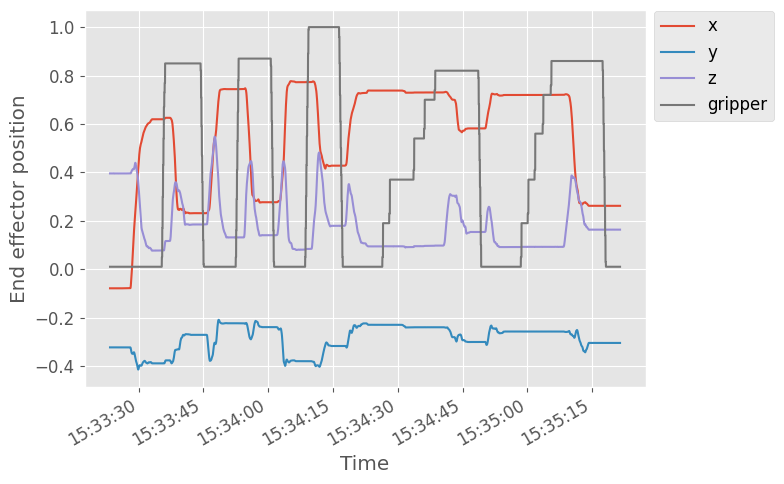

In [14]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [15]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
pprint(gt_segm_dict)

{'HigherLevel': {'cup': {'end': 1757363639, 'ini': 1757363626},
                 'fork': {'end': 1757363687, 'ini': 1757363658},
                 'napkin': {'end': 1757363655, 'ini': 1757363642},
                 'plate': {'end': 1757363623, 'ini': 1757363608},
                 'spoon': {'end': 1757363716, 'ini': 1757363690}},
 'LowerLevel': {'grasping': [{'end': 1757363617, 'ini': 1757363614},
                             {'end': 1757363634, 'ini': 1757363631},
                             {'end': 1757363650, 'ini': 1757363647},
                             {'end': 1757363681, 'ini': 1757363665},
                             {'end': 1757363708, 'ini': 1757363696}],
                'placing': [{'end': 1757363623, 'ini': 1757363617},
                            {'end': 1757363639, 'ini': 1757363634},
                            {'end': 1757363655, 'ini': 1757363650},
                            {'end': 1757363687, 'ini': 1757363681},
                            {'end': 1757363716, 'ini'

In [16]:
# for mvt in gt_segm_dict["LowerLevel"].keys():
#     if mvt == "reaching":
#         for idx, val in enumerate(gt_segm_dict["LowerLevel"][mvt]):
#             val["end"] = gt_segm_dict["LowerLevel"]["grasping"][idx]["end"]
#     elif mvt == "placing":
#         for idx, val in enumerate(gt_segm_dict["LowerLevel"][mvt]):
#             val["end"] = gt_segm_dict["LowerLevel"]["releasing"][idx]["end"]

# del gt_segm_dict["LowerLevel"]["grasping"]
# del gt_segm_dict["LowerLevel"]["releasing"]
# pprint(gt_segm_dict)

In [17]:
def filter_fork_spoon(gt_segm_dict, traj):
    ts_cut = np.min(
        [
            gt_segm_dict["HigherLevel"]["spoon"]["ini"],
            gt_segm_dict["HigherLevel"]["fork"]["ini"],
        ]
    )
    traj = traj[
        traj.timestamp
        < pd.Timestamp(
            dt.datetime.fromtimestamp(ts_cut) - dt.timedelta(hours=1),
            tz="EST",
        )
    ]
    return traj


# traj = filter_fork_spoon(gt_segm_dict=gt_segm_dict, traj=traj)

### Higher level movements

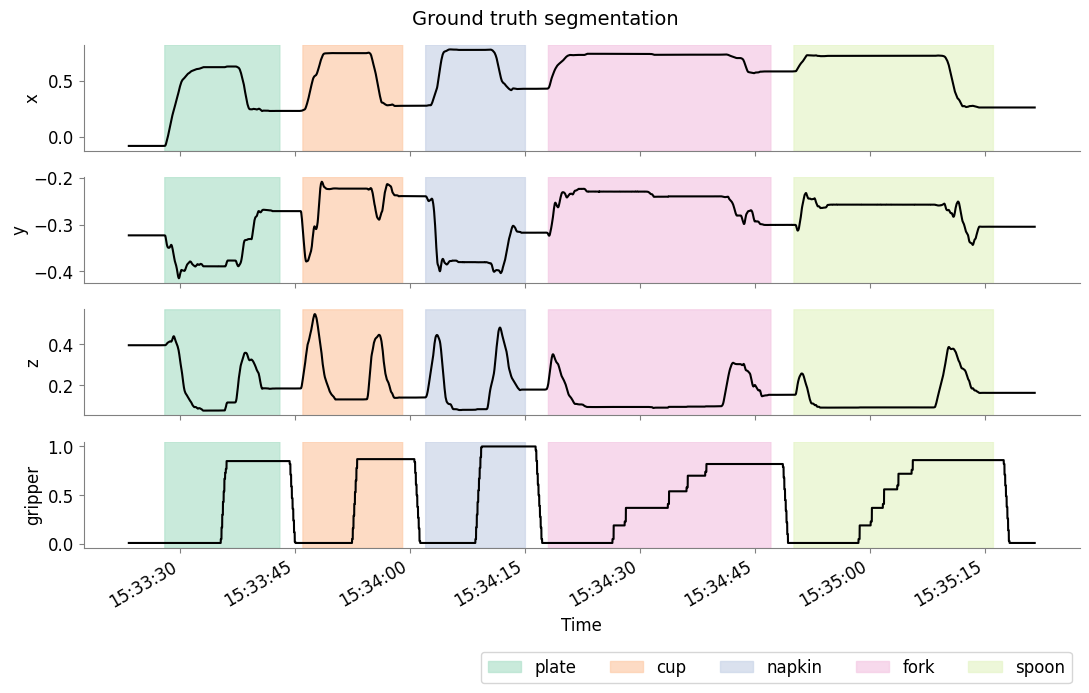

In [18]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    y_range = np.abs(y_high - y_low) / 2
    y_top = y_high + 0.1 * y_range
    y_bottom = y_low - 0.1 * y_range
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=y_bottom,
            y2=y_top,
            color=cmap[sect_i],
            alpha=0.7,
            # transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(
    # bbox_to_anchor=(0.75, -0.7), ncol=len(gt_segm_dict["HigherLevel"].keys())
    bbox_to_anchor=(1, -0.9),
    ncol=len(gt_segm_dict["HigherLevel"].keys()),
    fontsize=12,
)
fig.suptitle("Ground truth segmentation", fontsize=14)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Lower level movements

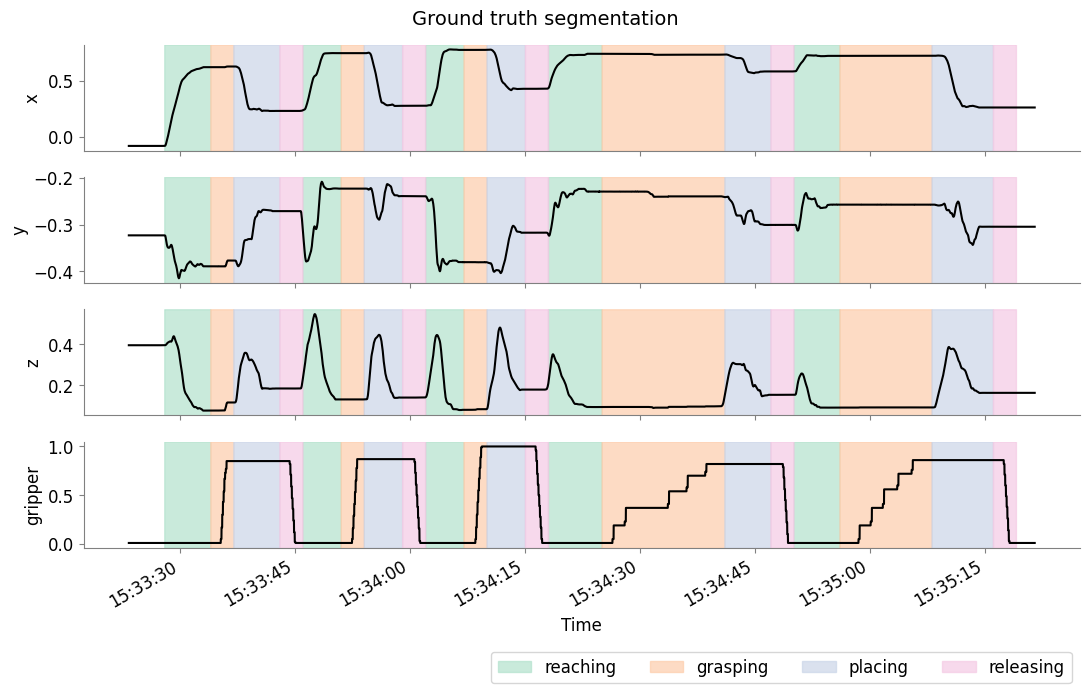

In [19]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    y_range = np.abs(y_high - y_low) / 2
    y_top = y_high + 0.1 * y_range
    y_bottom = y_low - 0.1 * y_range
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=y_bottom,
                    y2=y_top,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=y_bottom,
                    y2=y_top,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# axes[-1].legend(
#     bbox_to_anchor=(0.62, -0.7), ncol=len(gt_segm_dict["LowerLevel"].keys())
# )
axes[-1].legend(
    bbox_to_anchor=(1, -0.9), ncol=len(gt_segm_dict["LowerLevel"].keys()), fontsize=12
)
fig.suptitle("Ground truth segmentation", fontsize=14)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

## Segmentation

### Hyperparameters

In [20]:
# downsampling_factor = 200
resample_num = 2**8
print(f"Resampling to {resample_num} data points")

Resampling to 256 data points


In [21]:
# what_segments = "HigherLevel"
what_segments = "LowerLevel"

labels = gt_segm_dict[what_segments].keys()
labels

dict_keys(['reaching', 'grasping', 'placing', 'releasing'])

In [22]:
# Hyperparameters
learning_rate = 0.01
weight_decay = 0.001
# weight_decay = 0.1
num_epochs = 400
crf_hidden_size = 2**6
p_dropout = 0.0
print(f"CRF hidden size: {crf_hidden_size}")

CRF hidden size: 64


### Preprocessing

In [23]:
# true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
# for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#     sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#     if sect_i < len(true_cps):
#         true_cps[sect_i] = sect_dict_current["end"]
# true_cps

In [24]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.078980,-0.323035,0.395559,0.01
1,-0.079005,-0.323048,0.395506,0.01
2,-0.078984,-0.323033,0.395563,0.01
3,-0.078981,-0.323044,0.395566,0.01
4,-0.078974,-0.323039,0.395514,0.01
...,...,...,...,...
58998,0.261748,-0.304659,0.163334,0.01
58999,0.261760,-0.304677,0.163333,0.01
59000,0.261759,-0.304681,0.163327,0.01
59001,0.261747,-0.304674,0.163330,0.01


In [25]:
def get_closest_ts(traj_ts, query_idx):
    idx2ts = pd.Timestamp(
        dt.datetime.fromtimestamp(query_idx) - dt.timedelta(hours=1),
        tz="EST",
    )
    closest_idx = (traj_ts - idx2ts).abs().argmin()
    return closest_idx

In [26]:
def create_supervised_labels(what_segments, gt_segm_dict, traj):
    y = np.ones(shape=traj.shape[0]) * np.nan
    if what_segments == "HigherLevel":
        for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
            sect_dict_current = gt_segm_dict[what_segments][sect_key]
            idx_ini = get_closest_ts(
                traj_ts=traj.timestamp, query_idx=sect_dict_current["ini"]
            )
            idx_end = get_closest_ts(
                traj_ts=traj.timestamp, query_idx=sect_dict_current["end"]
            )
            if idx_ini == idx_end:
                warnings.warn(
                    "The start and end indexes of the section are the same at:\n"
                    f"`{what_segments}` segmentation, `{sect_key}` section"
                )
            y[idx_ini:idx_end] = sect_i

    elif what_segments == "LowerLevel":
        for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
            skill_current = gt_segm_dict[what_segments][sect_key]
            for skill_i, skill_val in enumerate(skill_current):
                idx_ini = get_closest_ts(
                    traj_ts=traj.timestamp, query_idx=skill_val["ini"]
                )
                idx_end = get_closest_ts(
                    traj_ts=traj.timestamp, query_idx=skill_val["end"]
                )
                if idx_ini == idx_end:
                    warnings.warn(
                        "The start and end indexes of the section are the same at:\n"
                        f"`{what_segments}` segmentation, `{sect_key}` section, skill index: {skill_i}"
                    )
                y[idx_ini:idx_end] = sect_i

    else:
        raise ValueError("what_segments can only be 'HigherLevel' or 'LowerLevel'")

    return y

In [27]:
y = create_supervised_labels(
    what_segments=what_segments, gt_segm_dict=gt_segm_dict, traj=traj
)
y

array([nan, nan, nan, ..., nan, nan, nan], shape=(59003,))

In [28]:
np.unique(y)

array([ 0.,  1.,  2.,  3., nan])

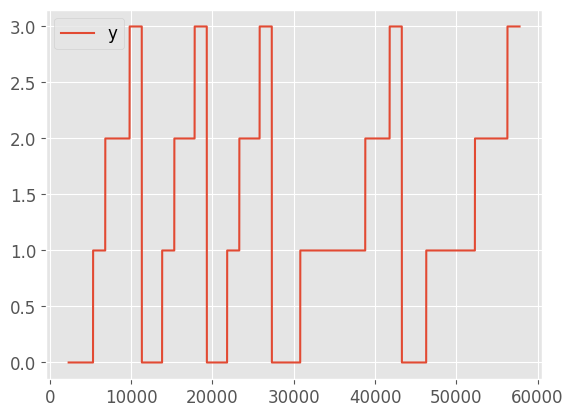

In [29]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y, label="y")
    ax.legend(loc="best")
    plt.show()

In [30]:
idx2filter = np.where(~np.isnan(y))
idx2filter

(array([ 2310,  2311,  2312, ..., 57778, 57779, 57780], shape=(55471,)),)

In [31]:
y_filtered = y[idx2filter]
y_filtered

array([0., 0., 0., ..., 3., 3., 3.], shape=(55471,))

In [32]:
np.unique(y_filtered)

array([0., 1., 2., 3.])

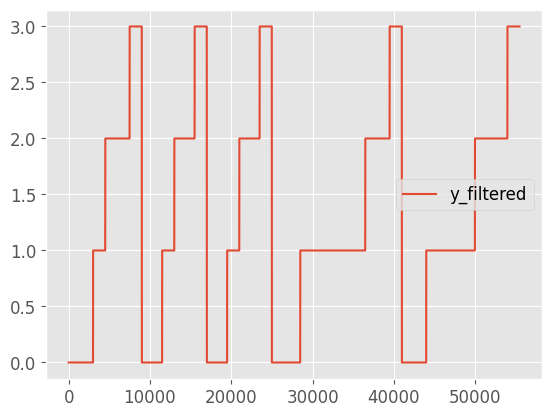

In [33]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_filtered, label="y_filtered")
    ax.legend(loc="best")
    plt.show()

In [34]:
X_filtered = X.iloc[idx2filter]
X_filtered

,x,y,z,gripper
2310,-0.078926,-0.323060,0.395548,0.01
2311,-0.078946,-0.323059,0.395536,0.01
2312,-0.078940,-0.323058,0.395538,0.01
2313,-0.078948,-0.323073,0.395527,0.01
2314,-0.078929,-0.323069,0.395526,0.01
...,...,...,...,...
57776,0.261758,-0.304680,0.163331,0.01
57777,0.261742,-0.304691,0.163333,0.01
57778,0.261758,-0.304664,0.163325,0.01
57779,0.261772,-0.304679,0.163344,0.01


In [35]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
X_scaled

array([[2.56708209e-05, 4.44542207e-01, 6.77456031e-01, 0.00000000e+00],
       [2.00187647e-06, 4.44546057e-01, 6.77430171e-01, 0.00000000e+00],
       [8.44414749e-06, 4.44553037e-01, 6.77433296e-01, 0.00000000e+00],
       ...,
       [3.98117123e-01, 5.33982905e-01, 1.84106796e-01, 0.00000000e+00],
       [3.98133455e-01, 5.33914008e-01, 1.84147003e-01, 0.00000000e+00],
       [3.98104229e-01, 5.33973007e-01, 1.84123757e-01, 0.00000000e+00]],
      shape=(55471, 4))

In [36]:
# X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
X_down = signal.resample(x=X_filtered, num=resample_num, axis=0)
X_down.shape

(256, 4)

In [37]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled.shape

(256, 4)

In [38]:
np.any(np.isinf(X_down_scaled)), np.any(np.isnan(X_down_scaled))

(np.False_, np.False_)

In [39]:
# y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(
#     int
# )
y_down = np.round(signal.resample(x=y_filtered, num=resample_num, axis=0)).astype(int)
y_down

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])

In [40]:
np.unique(y_down)

array([0, 1, 2, 3])

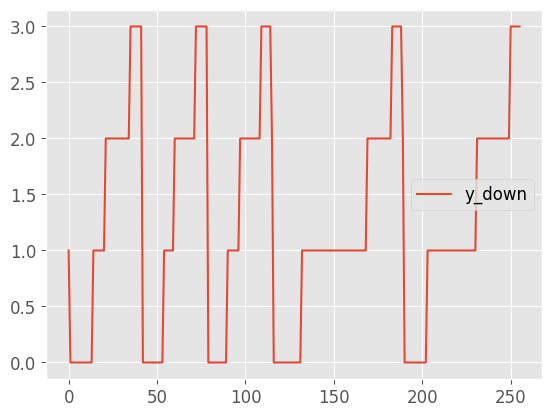

In [41]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_down, label="y_down")
    ax.legend(loc="best")
    plt.show()

In [42]:
# timestamp_down = traj.timestamp[
#     np.arange(start=traj.index.start, stop=traj.index.stop, step=downsampling_factor)
# ]
# timestamp_down

### Conditional Random Field

In [43]:
supervised_classes = torch.tensor(y_down, dtype=int)
supervised_observations = torch.tensor(X_down_scaled)

In [44]:
supervised_classes.shape, supervised_observations.shape

(torch.Size([256]), torch.Size([256, 4]))

In [45]:
supervised_classes

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])

In [46]:
supervised_observations.dtype

torch.float64

In [47]:
num_hidden_states = len(labels)  # number of hidden states
num_features = X.shape[1]  # number of continuous features

In [48]:
class CRF(nn.Module):
    def __init__(self, num_tags):
        super(CRF, self).__init__()
        self.num_tags = num_tags
        # Transition matrix: transition[i][j] is the score of transitioning from j to i
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))

    def forward(self, emissions, tags):
        # emissions: (batch_size, seq_length, num_tags)
        # tags: (batch_size, seq_length)
        if len(tags.shape) < 2:
            tags = tags.unsqueeze(dim=0)
        batch_size, seq_length = tags.size()

        # Calculate the numerator score
        numerator_score = self._compute_score(emissions, tags)
        # Calculate the denominator score
        denominator_score = self._compute_normalizer(emissions)

        return -torch.mean(numerator_score - denominator_score)

    def _compute_score(self, emissions, tags):
        if len(emissions.shape) < 3:
            emissions = emissions.unsqueeze(dim=0)
        batch_size, seq_length, num_tags = emissions.size()
        score = torch.zeros(batch_size)

        # Add the start transition score
        start_transitions = self.transitions[tags[:, 0], torch.tensor([0] * batch_size)]
        score += start_transitions

        # Add the emission scores and transition scores for each step
        for i in range(seq_length - 1):
            current_tags = tags[:, i]
            next_tags = tags[:, i + 1]
            score += emissions[torch.arange(batch_size), i, current_tags]
            score += self.transitions[next_tags, current_tags]

        # Add the end emission score
        score += emissions[
            torch.arange(batch_size), seq_length - 1, tags[:, seq_length - 1]
        ]

        return score

    def _compute_normalizer(self, emissions):
        if len(emissions.shape) < 3:
            emissions = emissions.unsqueeze(dim=0)
        batch_size, seq_length, num_tags = emissions.size()
        alphas = emissions[:, 0, :]

        for i in range(1, seq_length):
            emit_scores = emissions[:, i].unsqueeze(1)
            trans_scores = self.transitions.unsqueeze(0)
            next_alphas = alphas.unsqueeze(2) + emit_scores + trans_scores
            next_alphas = torch.logsumexp(next_alphas, dim=1)
            alphas = next_alphas

        return torch.logsumexp(alphas, dim=1)

In [49]:
class SimpleCRFModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags, p_dropout=0.0):
        super(SimpleCRFModel, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size, dtype=float)
        self.dropout = nn.Dropout(p=p_dropout)
        self.relu = nn.ReLU()
        self.emission_layer = nn.Linear(hidden_size, num_tags, dtype=float)
        self.crf = CRF(num_tags)

    def forward(self, inputs, tags):
        x = self.fc(inputs)
        x = self.relu(x)
        x = self.dropout(x)
        emissions = self.emission_layer(x)
        loss = self.crf(emissions, tags)
        return loss

    def predict(self, inputs):
        """Predict the most probable sequence of tags"""
        with torch.no_grad():
            x = self.fc(inputs)
            x = self.relu(x)
            # x = self.dropout(x)
            emissions = self.emission_layer(x)
            best_paths = viterbi_decode(
                emissions=emissions, transitions=self.crf.transitions
            )
            return best_paths.squeeze()

### Training

In [50]:
seq_length = len(supervised_classes)
num_tags = len(labels)
input_size = num_features

In [51]:
# Initialize the model
model = SimpleCRFModel(
    input_size=input_size, hidden_size=crf_hidden_size, num_tags=num_tags
)
model.train()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

losses = []
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    loss = model(inputs=supervised_observations, tags=supervised_classes)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  0%|          | 0/400 [00:00<?, ?it/s]

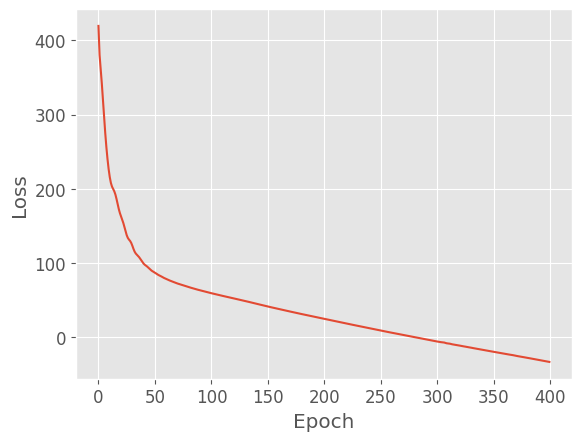

In [52]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    epochs = np.arange(num_epochs)
    ax.plot(epochs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    plt.show()

In [53]:
# def viterbi_decode(emissions, transitions):
#     batch_size, seq_length, num_tags = emissions.size()
#     alphas = emissions[:, 0, :]
#     backpointers = []

#     for i in range(1, seq_length):
#         emit_scores = emissions[:, i].unsqueeze(1)
#         trans_scores = transitions.unsqueeze(0)
#         next_alphas = alphas.unsqueeze(2) + emit_scores + trans_scores
#         max_scores, max_indices = torch.max(next_alphas, dim=1)
#         alphas = max_scores
#         backpointers.append(max_indices)

#     best_path_scores, best_last_tags = torch.max(alphas, dim=1)
#     best_paths = []
#     for i in range(batch_size):
#         best_path = [best_last_tags[i].item()]
#         for bp in reversed(backpointers):
#             best_path.append(bp[i, best_path[-1]].item())
#         best_path.reverse()
#         best_paths.append(best_path)

#     return best_paths

In [54]:
def viterbi_decode(emissions, transitions):
    if len(emissions.shape) < 3:
        emissions = emissions.unsqueeze(dim=0)
    batch_size, seq_length, num_tags = emissions.size()

    # Initialize with first position emissions + transition from tag 0 (START)
    alphas = emissions[:, 0, :] + transitions[:, 0].unsqueeze(0)
    backpointers = []

    for i in range(1, seq_length):
        emit_scores = emissions[:, i].unsqueeze(1)
        trans_scores = transitions.unsqueeze(0)
        next_alphas = alphas.unsqueeze(2) + emit_scores + trans_scores
        max_scores, max_indices = torch.max(next_alphas, dim=1)
        alphas = max_scores
        backpointers.append(max_indices)

    best_path_scores, best_last_tags = torch.max(alphas, dim=1)
    best_paths = []
    for i in range(batch_size):
        best_path = [best_last_tags[i].item()]
        for bp in reversed(backpointers):
            best_path.append(bp[i, best_path[-1]].item())
        best_path.reverse()
        best_paths.append(best_path)

    return torch.tensor(best_paths)

In [55]:
model.eval()
best_paths = model.predict(supervised_observations)
print(f"True classes:\n{supervised_classes}")
print(f"Predicted classes:\n{best_paths}")

True classes:
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])
Predicted classes:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2

In [56]:
# best_paths = best_paths.squeeze()
best_paths.shape, supervised_classes.shape

(torch.Size([256]), torch.Size([256]))

### Metrics & visualization

In [57]:
accuracy = accuracy_score(
    y_true=supervised_classes.flatten(), y_pred=best_paths.flatten()
)
f1 = f1_score(
    y_true=supervised_classes.flatten(), y_pred=best_paths.flatten(), average="macro"
)
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

Accuracy: 0.81640625
F1: 0.7864336711394015


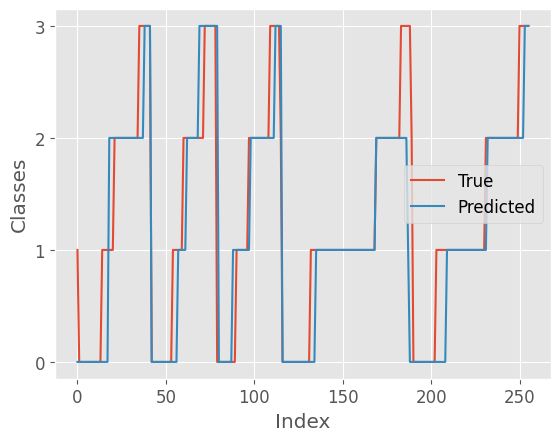

In [58]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(supervised_classes, label="True")
    ax.plot(best_paths, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(
        mpl.ticker.FixedFormatter(
            [str(elem.item()) for elem in supervised_classes.unique()]
        )
    )
    plt.show()

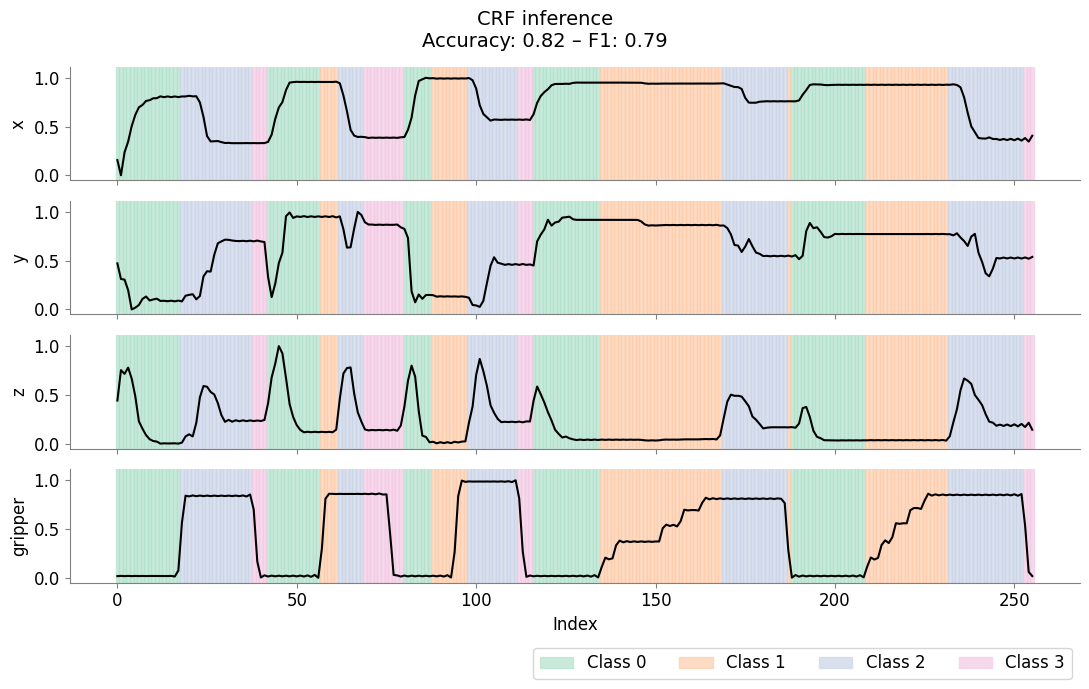

In [59]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(supervised_observations[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high]).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[best_paths == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# if what_segments == "LowerLevel":
#     bbox_to_anchor = (0.61, -0.6)
# elif what_segments == "HigherLevel":
#     bbox_to_anchor = (0.8, -0.6)
#     bbox_to_anchor = (1, -0.5)
axes[-1].legend(
    bbox_to_anchor=(1, -0.5), ncol=len(supervised_classes.unique()), fontsize=12
)
fig.suptitle(f"CRF inference\nAccuracy: {accuracy:3.2f} – F1: {f1:3.2f}", fontsize=14)
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Testing

In [60]:
def fit_predict_model(X_train, y_train, X_test):
    supervised_classes = y_train.to(dtype=int)
    supervised_observations = X_train
    supervised_obs_test = X_test

    # Initialize the model
    model = SimpleCRFModel(
        input_size=input_size, hidden_size=crf_hidden_size, num_tags=num_tags
    )
    model.train()

    # Define the optimizer
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = model(inputs=supervised_observations, tags=supervised_classes)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Predict
    model.eval()
    best_paths = model.predict(supervised_obs_test)

    return best_paths, losses

In [61]:
# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)
# for idx, (train_index, test_index) in enumerate(tscv.split(X_down_scaled)):
#     print(f"----- Split {idx + 1}/{n_splits} -----")
#     X_train = X_down_scaled[train_index]
#     X_test = X_down_scaled[test_index]
#     y_train = y_down[train_index]
#     y_test = y_down[test_index]

#     y_pred = fit_predict_model(X_train=X_train, y_train=y_train, X_test=X_test)

#     # Metrics
#     f1 = f1_score(y_test.flatten(), y_pred.flatten(), average="macro")
#     print(f"F1: {f1}")
#     accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
#     print(f"Accuracy: {accuracy}")  #:.2f}")
#     # logloss_metric = log_loss(y_true=y_test, y_pred=y_pred, labels=np.arange(len(labels)))
#     # print(f"Log Loss for 'multi:softprob': {logloss_metric}")#:.4f}")

In [62]:
bagfiles = get_bagfiles_from_json(ground_truth_segm_file=ground_truth_segm_file)
bagfiles

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [63]:
# bagfile_test = np.random.choice(bagfiles)
# bagfile_test

In [64]:
bagfile_test = bagfiles[filenum]
bagfile_test

PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag')

In [65]:
bagfiles_train = bagfiles
bagfiles_train.remove(bagfile_test)
bagfiles_train

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [66]:
# bagfiles_train = [bagfiles[2]]
# bagfile_test = bagfiles[3]

In [67]:
def preprocess_data(traj, what_segments, bagfile, resample_num):
    gt_segm_dict = get_ground_truth_segmentation(
        ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
    )
    # traj = filter_fork_spoon(gt_segm_dict=gt_segm_dict, traj=traj)
    X = traj.drop(columns=["timestamp"])
    y = create_supervised_labels(
        what_segments=what_segments, gt_segm_dict=gt_segm_dict, traj=traj
    )
    idx2filter = np.where(~np.isnan(y))
    assert X.shape[0] == y.shape[0], (
        "`X` and `y` don't have the same number of elements on dimension 0"
    )
    if idx2filter[0].size == 0:
        y_filtered = y
        X_filtered = X
    else:
        y_filtered = y[idx2filter]
        X_filtered = X.iloc[idx2filter]
    X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
    # X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
    X_down = signal.resample(x=X_filtered, num=resample_num, axis=0)
    minmaxscaler = MinMaxScaler(feature_range=(0, 1))
    X_down_scaled = minmaxscaler.fit_transform(X_down)
    # y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(
    #     int
    # )
    y_down = np.round(signal.resample(x=y_filtered, num=resample_num, axis=0)).astype(
        int
    )
    return torch.tensor(X_down_scaled), torch.tensor(y_down)

In [68]:
for idx, bagfile in enumerate(bagfiles_train):
    print(f"----- Processing file {idx + 1}/{len(bagfiles_train)} -----")
    tmp_traj = extract_eef_data_from_rosbag(bagfile)
    X_down_scaled, y_down = preprocess_data(
        traj=tmp_traj,
        what_segments=what_segments,
        bagfile=bagfile,
        resample_num=resample_num,
    )
    if idx == 0:
        X_train = X_down_scaled.unsqueeze(dim=0)
        y_train = y_down.unsqueeze(dim=0)
    else:
        X_train = torch.concat(
            (X_train.detach().clone(), X_down_scaled.unsqueeze(dim=0)),
            dim=0,
        )
        y_train = torch.concat(
            (y_train.detach().clone(), y_down.unsqueeze(dim=0)), dim=0
        )
X_train.shape, y_train.shape

----- Processing file 1/3 -----
Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag`


  0%|          | 0/165202 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓
----- Processing file 2/3 -----
Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag`


  0%|          | 0/191521 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓
----- Processing file 3/3 -----
Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag`


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


(torch.Size([3, 256, 4]), torch.Size([3, 256]))

In [69]:
traj_test = extract_eef_data_from_rosbag(bagfile_test)
X_test, y_test = preprocess_data(
    traj=traj_test,
    what_segments=what_segments,
    bagfile=bagfile_test,
    resample_num=resample_num,
)
X_test.shape, y_test.shape

Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag`


  0%|          | 0/186839 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


(torch.Size([256, 4]), torch.Size([256]))

In [70]:
# Train
y_pred, losses = fit_predict_model(X_train=X_train, y_train=y_train, X_test=X_test)

# Metrics
f1 = f1_score(y_test.flatten(), y_pred.flatten(), average="macro")
print(f"F1: {f1:.2f}")
accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
print(f"Accuracy: {accuracy:.2f}")

  0%|          | 0/400 [00:00<?, ?it/s]

F1: 0.64
Accuracy: 0.70


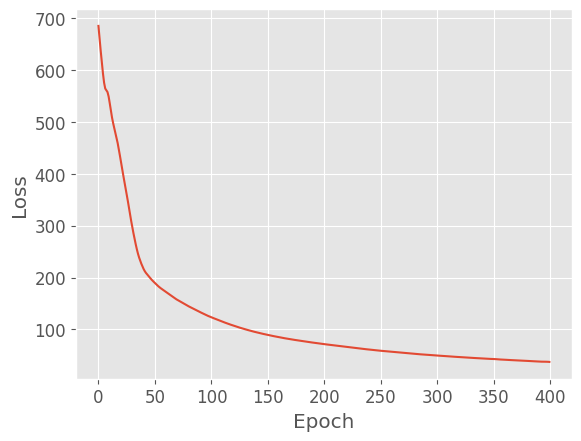

In [71]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    epochs = np.arange(num_epochs)
    ax.plot(epochs, losses)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    plt.show()

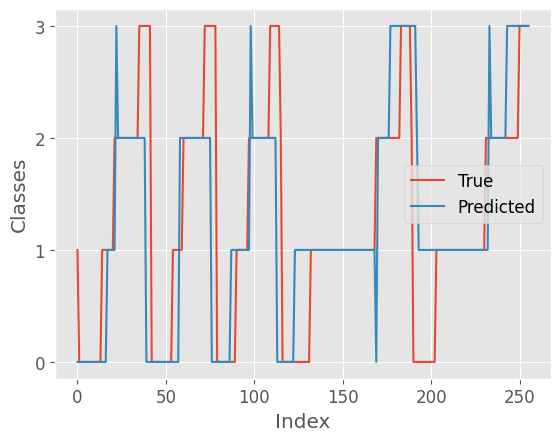

In [72]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_test, label="True")
    ax.plot(y_pred, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(
        mpl.ticker.FixedFormatter(
            [str(elem.item()) for elem in supervised_classes.unique()]
        )
    )
    plt.show()

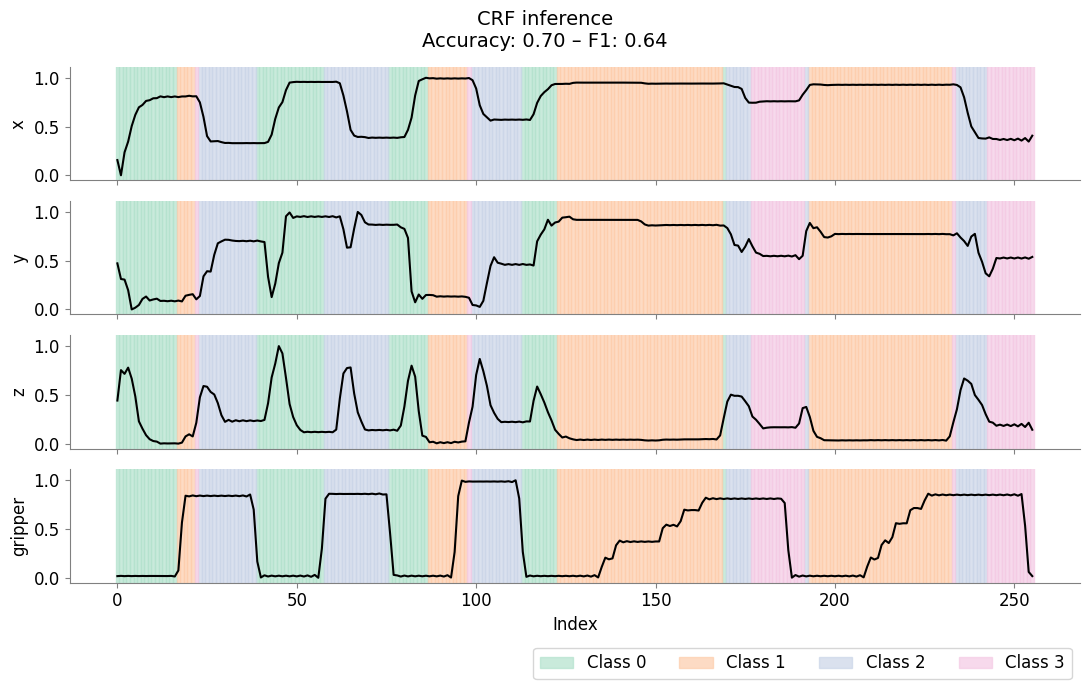

In [73]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(X_test[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high]).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[y_pred == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# if what_segments == "LowerLevel":
#     bbox_to_anchor = (0.61, -0.6)
# elif what_segments == "HigherLevel":
#     bbox_to_anchor = (0.8, -0.6)
#     bbox_to_anchor = (1, -0.5)
axes[-1].legend(
    bbox_to_anchor=(1, -0.5), ncol=len(supervised_classes.unique()), fontsize=12
)
fig.suptitle(f"CRF inference\nAccuracy: {accuracy:3.2f} – F1: {f1:3.2f}", fontsize=14)
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()